# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


### test Fortran

In [21]:
import os
d = 1.12554
delta = 1.14078
alpha = 0
D = 40.0
lamda = 12.0
eta = 1.23
A = 0.0505
para = str(d)+' '+str(delta)+' '+str(alpha)+' '+str(D)+' '+str(lamda)+' '+str(eta)+' '+str(A)
exe ='./a.out '+' '+para 
ret = os.system(exe)
f = os.popen(exe)
print("hello=",f.readline())
f.close()
#print('./a.out '+' '+para)


   8.8757144855184248E-005
hello=    8.8757144855184248E-005



# MCMC_NEATM

## define const & import

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 21.3
G = 0.15
Ndd = 15
lamdai = [12,22]

In [ ]:
import os
import numpy as np
from scipy import integrate
def calcPlanckLambda(lambd, T):
    """
    The wavelength form of Planck's law. Given a wavelength or array
    of wavelengths, returns the blackbody distribution in SI units
    with characteristic temperature T in Kelvin.

    Where wavelength or temperature are less than zero, returns zero.

    Parameters
    ----------
    lambd : float or `~numpy.ndarray` (N)
        Wavelength in m.
    T : float or `~numpy.ndarray` (N)
        Temperature in K.

    Returns
    -------
    float or `~numpy.ndarray` (N)
        Returns Planck function in W sr^-1 m^-3.

    See Also
    --------
    calcPlanckNu : The frequency form of Planck's law
    """
    return np.where(
        (lambd <= 0.0) | (T <= 0.0),
        0.0,
        (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
        )



def calcDirectionCosine( theta, phi, alpha):
        """
        Calculates the direction cosine to the observer. The observer and Sun are assumed 
        to be located in the equatorial plane of the asteroid. The Sun is located at phi = 0
        and the observer at phi = alpha.

        Parameters
        ----------
        theta : float or `~numpy.ndarray`
            Polar angle in radians.
        phi : float or `~numpy.ndarray`
            Azimuthal angle in radians.
        alpha : float or `~numpy.ndarray`
            Phase angle in radians.

        Returns
        -------
        float or `~numpy.ndarray`
            Direction cosine towards the observer.
        """
        return np.maximum(0.0, np.cos(theta) * np.cos(phi - alpha))

def calcT( theta, phi, T_ss):
    """
    Calculates the temperature at a specific angular position on the surface of 
    an asteroid. The subsolar point is located at (theta, phi) = (0, 0)
    where the temperature is defined to be the subsolar temperature.

    Returns zero K for any angular positions on the night side of an asteroid
    (theta > pi/2).

    Parameters
    ----------
    theta : float or `~numpy.ndarray`
        Latitude in radians.
    phi : float or `~numpy.ndarray`
        Longitude in radians.
    T_ss : float or `~numpy.ndarray`
        Subsolar temperature in K.

    Returns
    -------
    float or `~numpy.ndarray`
        Temperature at an angular specific point on the asteroid in K.
    """
    return T_ss * np.maximum(0.0, np.cos(theta) * np.cos(phi))**0.25

def calcFluxLambdaEmitted( theta, phi, lambd, T_ss):
    """
    Calculates the flux emitted at a specific angular point on
    the surface of an asteroid of size unity as a function of angular position,
    wavelength and the subsolar temperature.

    Returns flux in units of W m^-3.

    Parameters
    ----------
    theta : float or `~numpy.ndarray`
        Latitude in radians.
    phi : float or `~numpy.ndarray`
        Longitude in radians.
    lambd : float or `~numpy.ndarray`
        Wavelength in m.
    T_ss : float or `~numpy.ndarray`
        Subsolar temperature in K.

    Returns
    -------
    float or `~numpy.ndarray`
        Flux emitted at a specific angular point on the asteroid in units of W m^-3.
    """
    return np.pi * calcPlanckLambda(lambd, calcT(theta, phi, T_ss))

def calcTotalFluxLambdaEmitted( lambd, T_ss):
    """
    Calculates the total flux emitted at the surface of an asteroid
    of size unity as a function of wavelength and the subsolar temperature.

    Returns flux in units of W m^-3.

    Parameters
    ----------
    lambd : float or `~numpy.ndarray`
        Wavelength in m.
    T_ss : float or `~numpy.ndarray`
        Subsolar temperature in K.

    Returns
    -------
    float
        Total flux emitted in units of W m^-3.
    """
    return integrate.dblquad(lambda theta, phi, lambd, T_ss:
                                (calcFluxLambdaEmitted(theta, phi, lambd, T_ss)
                                * surfaceElement(theta, phi)),
                                -np.pi/2,
                                np.pi/2,
                                lambda theta: -np.pi/2,
                                lambda theta: np.pi/2,
                                args=[lambd, T_ss])[0]

def calcFluxLambdaEmittedToObs( theta, phi, lambd, T_ss, alpha):
    """
    Calculates the flux emitted at a specific angular point on
    the surface of an asteroid of size unity towards an observer at
    phase angle alpha as a function of angular position,
    wavelength, subsolar temperature and phase angle.

    Returns flux in units of W m^-3.

    Parameters
    ----------
    theta : float or `~numpy.ndarray`
        Latitude in radians.
    phi : float or `~numpy.ndarray`
        Longitude in radians.
    lambd : float or `~numpy.ndarray`
        Wavelength in m.
    T_ss : float or `~numpy.ndarray`
        Subsolar temperature in K.
    alpha : float or `~numpy.ndarray`
        Phase angle in radians.

    Returns
    -------
    float or `~numpy.ndarray`
        Flux in units of W m^-3 at a specific angular point on the asteroid emitted 
        to an observer located in the direction of alpha.
    """
    return (calcPlanckLambda(lambd, calcT(theta, phi, T_ss))
            * calcDirectionCosine(theta, phi, alpha))

def calcTotalFluxLambdaEmittedToObs( lambd, T_ss, alpha):
    """
    Calculates the total flux emitted at the surface of an asteroid
    of size unity towards an observer at phase angle alpha
    as a function of wavelength, subsolar temperature and phase angle.

    Returns flux in units of W m^-3.

    Parameters
    ----------
    lambd : float or `~numpy.ndarray`
        Wavelength in m.
    T_ss : float or `~numpy.ndarray`
        Subsolar temperature in K.
    alpha : float or `~numpy.ndarray`
        Phase angle in radians.

    Returns
    -------
    float
        Total flux in units of W m^-3 emitted to an observer
        located in the direction of alpha.
    """
    return integrate.dblquad(lambda theta, phi, lambd, T_ss, alpha:
                                (calcFluxLambdaEmittedToObs(theta, phi, lambd, T_ss, alpha)
                                * surfaceElement(theta, phi)),
                                -np.pi/2 + alpha,
                                np.pi/2 + alpha,
                                lambda theta: -np.pi/2,
                                lambda theta: np.pi/2,
                                args=[lambd, T_ss, alpha])[0]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

In [23]:
#ret = os.popen('./a.out 2 6')
#a1 = ret.readlines()
def Model_neatm_hhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A)+' '+str(Ndd))
        #print('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A))
        flux[i] = ret
    for i in range(int(nn/2),nn):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda2)+' '+str(A)+' '+str(Ndd))
        flux[i] = ret
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

## read data file

处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [26]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = namelist[4].lower()
name = '2010pw58'
name

'2010pw58'

计算delta d 看看对不对

In [27]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
#print(obsec)
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
alpha_N/pi*180

[0.25813743 0.25808508 0.25803259 0.25797977 0.25776627 0.25760371
 0.25754898 0.25732791 0.25727211 0.25727201 0.25721597 0.2571597
 0.25715959 0.25710309 0.25704624 0.25698927 0.25693195 0.25675884
 0.15993854 0.15993851 0.15991336 0.1598895  0.15986693 0.15985611
 0.15984564 0.15983547 0.25813743 0.25808508 0.25803259 0.25797977
 0.25776627 0.25760371 0.25754898 0.25732791 0.25727211 0.25727201
 0.25721597 0.2571597  0.25715959 0.25710309 0.25704624 0.25698927
 0.25693195 0.25675884 0.15993854 0.15993851 0.15991336 0.1598895
 0.15986693 0.15985611 0.15984564 0.15983547]


array([76.12947436, 76.10532156, 76.08124946, 76.05716513, 75.9612638 ,
       75.88971952, 75.86590881, 75.77109734, 75.74750191, 75.7474566 ,
       75.72389491, 75.7003665 , 75.70032132, 75.67682693, 75.65332069,
       75.62989342, 75.60645434, 75.53642835, 76.1326352 , 76.13271646,
       76.21753658, 76.30269613, 76.3881928 , 76.4311077 , 76.47402361,
       76.51710583, 76.12947436, 76.10532156, 76.08124946, 76.05716513,
       75.9612638 , 75.88971952, 75.86590881, 75.77109734, 75.74750191,
       75.7474566 , 75.72389491, 75.7003665 , 75.70032132, 75.67682693,
       75.65332069, 75.62989342, 75.60645434, 75.53642835, 76.1326352 ,
       76.13271646, 76.21753658, 76.30269613, 76.3881928 , 76.4311077 ,
       76.47402361, 76.51710583])

/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


[2.87707417 2.87875419 2.88043616 2.88212657 2.8889337  2.89409237
 2.89582469 2.90280034 2.90455587 2.90455924 2.90632013 2.90808639
 2.90808979 2.90986141 2.91164186 2.91342427 2.91521554 2.92061508
 7.58943576 7.58943135 7.58474286 7.57987266 7.57482091 7.57222451
 7.56958782 7.56690067 3.18409226 3.18615096 3.1882113  3.19028126
 3.19860954 3.20491336 3.2070288  3.2155399  3.21768005 3.21768417
 3.21983013 3.22198194 3.22198608 3.22414369 3.22631133 3.22848065
 3.23066005 3.23722522 8.35815205 8.35814638 8.3521387  8.34593177
 8.33952582 8.33624515 8.33292116 8.32954108]


/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


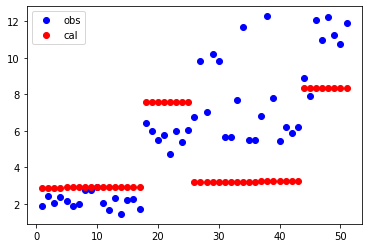

In [28]:

obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat = np.loadtxt(f'w34_{name}.txt')

#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)

#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)

#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)

#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
y = obsdat
nt = np.arange(len(d_N))
theta = [1.5,100]
flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
#plt.plot(nt,flux,label = 'hhq')
print(flux)
plt.plot(nt[1:60],obsdat[1:60],'bo',label = 'obs')
plt.plot(nt[1:60],flux[1:60],'ro',label = 'cal')
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()
lenthi = [8,30,200]
dddd = (lenthi[1]-lenthi[0])/lenthi[2]
lenth = lenthi[0]
D = 136
pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
q = 0.29+0.684*G
A = q*pv
flamda = []
nlenth  = []
for i in range(lenthi[2]):
    lenth = lenth+dddd
    nlenth.append(lenth)
    flamda.append((Model_neatm_hhq(Ndd,d_N[1],delta_N[1],alpha_N[1],D,lenth,1.2,A)))
#plt.plot(nlenth,flamda,label = 'cal')  


## define MCMC_function

In [29]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,10]
D_gss = [1,800]

In [30]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [31]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [32]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 1000/1000 [19:23<00:00,  1.16s/it]


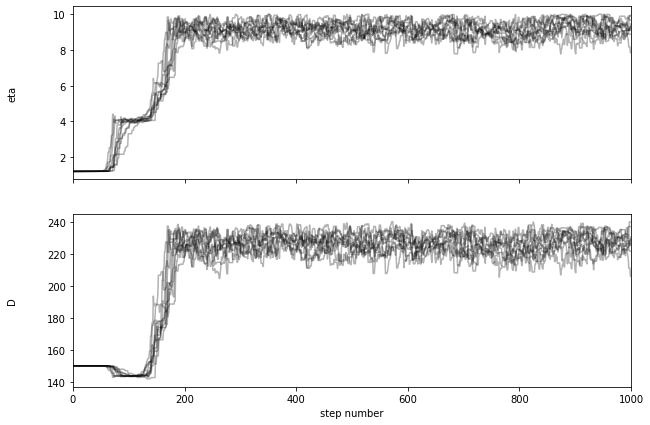

In [33]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


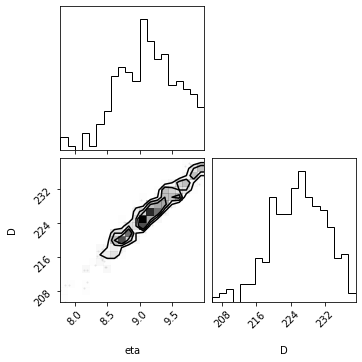

In [34]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

## truth 0.213

In [35]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.1041763588913609


eta_fit =  9.140613184695614 D_fit=  226.27699044812888 pv =  0.1041763588913609
loss =  16.454057921391637


/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_238130/4018011249.py:43: RuntimeWarning: overflow encountered in exp
 

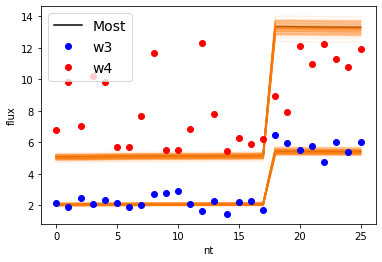

In [36]:
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_jhx(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(nt[0:half], yt[0:half],"k")
plt.plot(nt[0:half], yt[half:leni],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
#print(nt)
#print(len(flat_samples))

#print(nt[0:half])
#print(nt[half:leni])
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_jhx(sample,x,lamdai)
    plt.plot(nt[0:half], plotmodel[0:half], "C1", alpha=0.1)
    plt.plot(nt[0:half], plotmodel[half:leni], "C1", alpha=0.1)
plt.plot(nt[0:half],y[0:half],'bo',label = 'w3')
plt.plot(nt[0:half],y[half:leni],'ro',label = 'w4')
#plt.errorbar(nt[0:half], y[0:half], yerr=yerr[0:half], fmt=".k", capsize=0)
#plt.errorbar(nt[0:half], y[half:leni], yerr=yerr[half:leni], fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
